# Reverse engineering ngmix' gaussian moments - part 2

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import ngmix
import autometacal
import tensorflow as tf

Get a galaxy:

In [3]:
scale = .2
stamp_size=51
gal, psf = autometacal.data.galaxies.make_data(img_noise=0.000005,gal_g1=[0.2],gal_g2=[0.1],scale=scale)

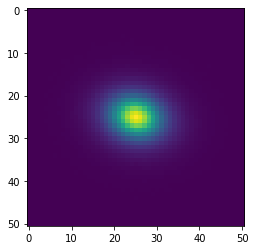

In [4]:
imshow(gal.numpy()[0])
obs=ngmix.Observation(gal.numpy()[0],jacobian=ngmix.DiagonalJacobian(row=25, col=25, scale=.2))

Set a fitter with Gaussian moments:

In [5]:
weight_fwhm = scale*stamp_size/2 # <- this sets everything for the window function
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
fitter._measure_moments(obs)

{'flags': 0,
 'npix': 2601,
 'wsum': 28.391886409860447,
 'sums': array([-1.40819422e-06, -7.50545493e-06,  8.63656546e-03,  4.36321380e-03,
         4.96443801e-02,  3.29991413e-02]),
 'sums_cov': array([[ 1.36575550e+00, -1.54954090e-18, -1.90131368e-16,
         -2.00238589e-17, -1.15060956e-17, -7.90294975e-18],
        [-2.41076165e-18,  1.36575550e+00, -2.89693738e-17,
         -5.68748743e-17, -8.08188016e-17, -1.94671994e-18],
        [-1.89264642e-16,  1.43853723e-17,  1.21351863e+01,
          2.98011602e-17,  4.72483448e-17,  2.22713847e-15],
        [-6.14268293e-18, -5.75253956e-17,  2.29164764e-17,
          1.26799874e+01, -3.73507648e-17, -3.52111596e-18],
        [-9.28348110e-18, -6.00800469e-17,  9.92976724e-17,
         -6.49979202e-17,  2.48151738e+01,  2.73151100e+00],
        [-7.90294975e-18, -1.94671994e-18,  2.22713847e-15,
         -3.52111596e-18,  2.73151100e+00,  5.88419538e-01]]),
 'pars': array([-4.26736624e-05, -2.27443947e-04,  2.61720915e-01,  1.32222

In [6]:
pix_weights = tf.ones([51,51])
jake=autometacal.tf_ngmix.make_diagonal_jacobian(25,25,scale=.2)
image = gal.numpy()[0]
pixels=autometacal.tf_ngmix.make_pixels(image,pix_weights,jake)
T = autometacal.tf_ngmix.fwhm_to_T(weight_fwhm)
weights = autometacal.tf_ngmix.create_gmix([0.,0.,0.,0.,T,1.],'gauss')
autometacal.tf_ngmix.get_moments(weights,pixels)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.17396869, 0.08788938], dtype=float32)>

In [7]:
weights

<tf.Tensor: shape=(1, 13), dtype=float32, numpy=
array([[29.471672  ,  0.        ,  0.        ,  4.6905622 ,  0.        ,
         4.6905622 , 22.001373  ,  1.        ,  0.21319406,  0.        ,
         0.21319406,  0.03393089,  1.        ]], dtype=float32)>

## Testing

In [8]:
from numpy.testing import assert_allclose
def test_fitting():
  """
  This test generates a simple galaxy and measure moments with ngmix, vs.
  tf_ngmix.
  """
  #create galaxy image
  scale = .2
  stamp_size=51
  gal, _ = autometacal.data.galaxies.make_data(img_noise=0.0005,
                                                 gal_g1=[0.],
                                                 gal_g2=[0.5],
                                                 scale=scale)
  image = gal.numpy()[0]
  
  #ngmix version
  obs=ngmix.Observation(image,
                        jacobian=ngmix.DiagonalJacobian(row=25, 
                                                        col=25, 
                                                        scale=.2))
  weight_fwhm = scale*stamp_size/2. 
  fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
  result_ngmix =fitter._measure_moments(obs)['e']
  
  #our version:
  pix_weights = tf.ones([51,51])
  #make jacobian
  jake=autometacal.tf_ngmix.make_diagonal_jacobian(25,25,scale=.2)
  #make pixels
  pixels=autometacal.tf_ngmix.make_pixels(image,pix_weights,jake)
  
  T = autometacal.tf_ngmix.fwhm_to_T(weight_fwhm)
  weights = autometacal.tf_ngmix.create_gmix([0.,0.,0.,0.,T,1.],'gauss')
  result_tf_ngmix = autometacal.tf_ngmix.get_moments(weights,pixels)
  
  
  #test
  assert_allclose(result_ngmix, result_tf_ngmix, rtol=1e-5)


In [9]:
test_fitting()